In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statistics as stats
import math
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.express as px


# importing and subsetting the data

# data obtained from 'https://forge.scilab.org/index.php/p/rdataset/source/tree/master/csv/datasets/USArrests.csv'

# documentation for data: 'https://www.rdocumentation.org/packages/datasets/versions/3.6.2/topics/USArrests'

dframe = pd.read_csv('USArrests.csv')

dframe.rename(columns = {'Unnamed: 0':'State'}, inplace = True) 


y = dframe['Rape']

x = dframe[['Assault', 'UrbanPop', 'Murder']]

x = sm.add_constant(x) 

mod = sm.OLS(y, x).fit()
predict = mod.predict(x) 

print_mod = mod.summary()
print(print_mod)

# plotting the data

fig = px.scatter_3d(dframe, x='UrbanPop', y='Assault', z='Rape',
              color='State')


fig.update_layout(scene = dict(
                    xaxis_title='Urban Population %',
                    yaxis_title='Assault Arrests per 100,000 residents',
                    zaxis_title='Rape Arrests per 100,000 residents',), font=dict(size=8))


fig.show()


                            OLS Regression Results                            
Dep. Variable:                   Rape   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     16.39
Date:                Sun, 29 Mar 2020   Prob (F-statistic):           2.21e-07
Time:                        18:17:21   Log-Likelihood:                -164.13
No. Observations:                  50   AIC:                             336.3
Df Residuals:                      46   BIC:                             343.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4741      4.696     -0.527      0.6

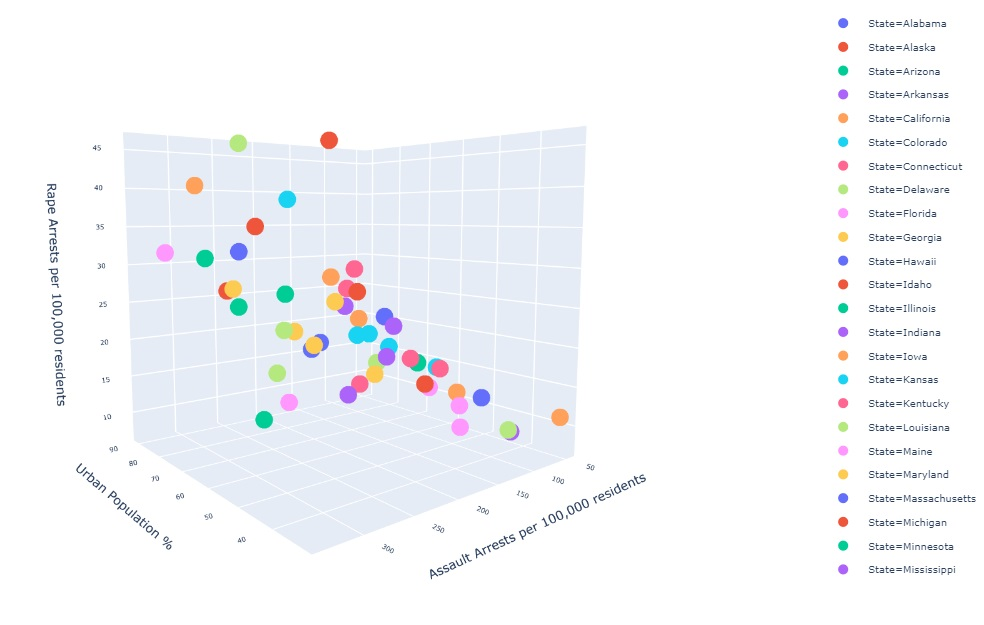

In [4]:
from IPython.display import Image
Image(filename='mul_lin_regress_rape.jpg')